In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
%matplotlib inline

from collections import defaultdict
stop_words = frozenset(
    ["is", "are", "you", "i", "me", "my", "the", "a", "an", "and", "to", "his", "her", "that", "they", "on", "it", "was", "if", "be", "in", "so", "with", "", "s", "of", "for", "its", "at", "their"]
)


In [13]:
stock_price = pd.read_csv("../dataset/stock_price_data/Pfizer_data.csv")
stock_price['Date'] = pd.to_datetime(stock_price['Date'], format = '%Y-%m-%d')

In [14]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,35.930000,36.020000,35.430000,35.430000,34.060383,20885200
1,2019-10-02,35.259998,35.270000,34.660000,34.700001,33.358604,21307400
2,2019-10-03,34.709999,35.470001,34.599998,35.450001,34.079609,20945100
3,2019-10-04,35.490002,35.980000,35.450001,35.930000,34.541054,17139800
4,2019-10-07,35.820000,36.259998,35.799999,35.830002,34.444920,11156900


In [33]:
pfizer_close = stock_price['Close']
n = 7
moving_avg = [sum(pfizer_close[i-n:i])/n for i in range(n, len(pfizer_close))]
moving_stdev = (pfizer_close[n:] - moving_avg)**2

m = 3
moving_stdev_smooth = [sum(moving_stdev[i-m:i])/m for i in range(m,len(moving_stdev))]

dates = pd.to_datetime(stock_price["Date"], format = '%Y-%m-%d')
dates.head()


0   2019-10-01
1   2019-10-02
2   2019-10-03
3   2019-10-04
4   2019-10-07
Name: Date, dtype: datetime64[ns]

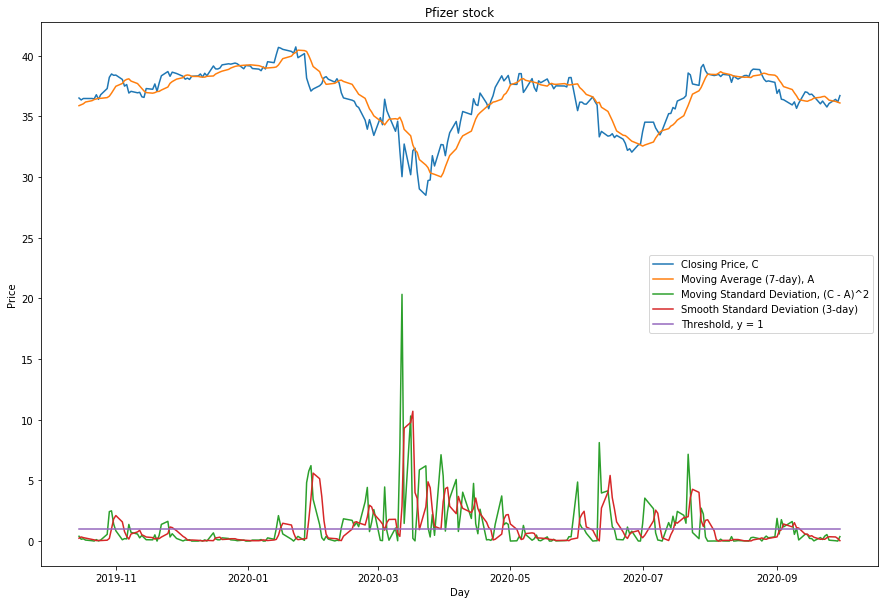

In [34]:
plt.plot(dates[n+m:], pfizer_close[n+m:], label="Closing Price, C")
plt.plot(dates[n+m:], moving_avg[m:], label=f"Moving Average ({n}-day), A")
plt.plot(dates[n+m:], moving_stdev[m:], label="Moving Standard Deviation, (C - A)^2")
plt.plot(dates[n+m:], moving_stdev_smooth, label=f"Smooth Standard Deviation ({m}-day)")
plt.plot(dates[n+m:], [1]*(len(dates)-m-n), label="Threshold, y = 1")
plt.title("Pfizer stock")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
plt.rcParams["figure.figsize"]=(15,10) # (width, height)
plt.show()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,48.299999,49.189999,47.826000,48.938000,48.938000,30813000
1,2019-10-02,48.658001,48.930000,47.886002,48.625999,48.625999,28157000
2,2019-10-03,46.372002,46.896000,44.855999,46.605999,46.605999,75422500
3,2019-10-04,46.321999,46.956001,45.613998,46.285999,46.285999,39975000
4,2019-10-07,45.959999,47.712002,45.709999,47.543999,47.543999,40321000


0   2019-10-01
1   2019-10-02
2   2019-10-03
3   2019-10-04
4   2019-10-07
Name: Date, dtype: datetime64[ns]

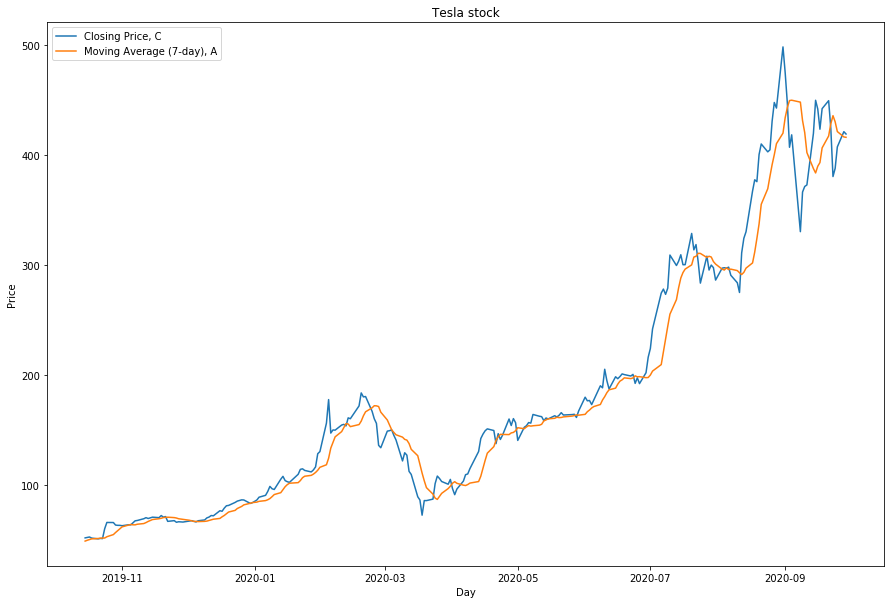

In [60]:
stock_price_tsla = pd.read_csv("../dataset/stock_price_data/TSLA.csv")
stock_price_tsla['Date'] = pd.to_datetime(stock_price_tsla['Date'], format = '%Y-%m-%d')
display(stock_price_tsla.head())
tsla_close = stock_price_tsla['Close']
n = 7
moving_avg_tsla = [sum(tsla_close[i-n:i])/n for i in range(n, len(tsla_close))]
moving_stdev_tsla = (tsla_close[n:] - moving_avg_tsla)**2

m = 3
moving_stdev_smooth_tsla = [sum(moving_stdev_tsla[i-m:i])/m for i in range(m,len(moving_stdev_tsla))]

dates_tsla = pd.to_datetime(stock_price_tsla["Date"], format = '%Y-%m-%d')
display(dates_tsla.head())
plt.plot(dates_tsla[n+m:], tsla_close[n+m:], label="Closing Price, C")
plt.plot(dates_tsla[n+m:], moving_avg_tsla[m:], label=f"Moving Average ({n}-day), A")
# plt.plot(dates_tsla[n+m:], moving_stdev_tsla[m:], label="Moving Standard Deviation, (C - A)^2")
# plt.plot(dates_tsla[n+m:], moving_stdev_smooth_tsla, label=f"Smooth Standard Deviation ({m}-day)")
# plt.plot(dates_tsla[n+m:], [500]*(len(dates_tsla)-m-n), label="Threshold, y = 1000")
plt.title("Tesla stock")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
plt.rcParams["figure.figsize"]=(15,10) # (width, height)
plt.show()


In [55]:
rgx = r"\b[A-Za-z]*(?![\d]+)[A-Za-z]*\b"
regex_splitter = re.compile(rgx)

def get_company_vicinity(text, name):
    # for each occurance of pfizer, select ± 30 words and ignore the rest
    split_text = np.array(regex_splitter.findall(text))
    pf_index = np.where(split_text == name)
    ret_arr = []
    for idx in pf_index[0]:
        words30 = split_text[idx:idx+31]
        if len(words30) > 1:
            ret_arr.append(words30)
    return ret_arr

def load_text(p, name):
    doc_list = []
    for f in os.listdir(p):
        if f[0] == '.':
            continue
        date = pd.Timestamp((f.split(','))[0])
        with open(os.path.join(p,f),'r') as doc:
            text_frag_array = get_company_vicinity(doc.read(), name)
            for tx in text_frag_array:
                
                content = (date, " ".join(tx))
                doc_list.append(content)
    return np.array(doc_list)

def fix_weekends(txt_df):
#     txt_df['Dates'] = pd.to_datetime(txt_df.Dates)
    dts = txt_df['Dates'][:]
    for date in range(len(dts)):
        if (dts[date].dayofweek - 4) > 0:
            dts[date] = dts[date] + (pd.offsets.Day(7 - (dts[date].dayofweek)))
    txt_df['Dates'] = dts
    
def load_volatility(p, moving_stdev_smooth_, volatility_threshold=1):
    labels = [(1,dates[i+m+n]) if j > volatility_threshold else (0,dates[i+m+n]) for i,j in enumerate(moving_stdev_smooth_)]
    return np.array(labels)

def load_data(text_path, price_path,name,moving_stdev_smooth_, volatility_threshold=1):
    text = load_text(text_path, name)
    text_df = pd.DataFrame({'Dates':pd.to_datetime(text[:,0]),'Text':text[:,1]})
    fix_weekends(text_df)
    volatility = load_volatility(price_path, moving_stdev_smooth_, volatility_threshold)
    vol_df = pd.DataFrame({'Dates':pd.to_datetime(volatility[:,1]),'Volatility':volatility[:,0]})
    return text_df.merge(vol_df, on='Dates', how='left')
        
    

In [7]:

pfizer_text_path = '../dataset/marketwatch_articles/Pfizer'
text = load_text(pfizer_text_path, 'Pfizer')

pfizer_price_path = '../dataset/stock_price_data/Pfizer_data.csv'
data = load_data(pfizer_text_path, pfizer_price_path, 'Pfizer', moving_stdev_smooth,1)

display(data)
dat = data[data['Volatility'].notna()]
X = dat['Text']
y = dat['Volatility']
print("word_count = " + str(sum([len(i.split(" "))for i in X])))
y=y.astype('int')

,Dates,Text,Volatility
0,2019-11-08,Pfizer drug fails to meet endpoints in ...,0
1,2019-11-08,Pfizer PFE said Friday that a late st...,0
2,2019-11-08,Pfizer formed an alliance in to develop...,0
3,2019-11-08,Pfizer have fallen year to date while ...,0
4,2020-08-26,Pfizer PFE A move in any of the ind...,0
...,...,...,...
1150,2020-08-12,Pfizer and BioNTech would price its vacc...,0
1151,2020-05-06,Pfizer PFE Microsoft MSFT and Walt D...,0
1152,2020-07-20,Pfizer BioNTech COVID vaccine candidate ...,1
1153,2020-07-22,Pfizer stock s implied premarket price g...,1


word_count = 34607


In [8]:
print(type(y.values[207]))
print(data.Dates.values[207])
data.to_csv('pfizer_processed.csv')

<class 'numpy.int64'>
2020-08-19T00:00:00.000000000


In [57]:
tesla_text_path = '../dataset/Tesla_data'
text = load_text(tesla_text_path, 'Tesla')

tesla_price_path = '../dataset/stock_price_data/TSLA.csv'
data = load_data(tesla_text_path, tesla_price_path, 'Tesla', moving_stdev_smooth_tsla, 500)

display(data)
dat = data[data['Volatility'].notna()]
X = dat['Text']
y = dat['Volatility']
print(sum(y))
print("word_count = " + str(sum([len(i.split(" "))for i in X])))
y=y.astype('int')

/Users/suraj/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


,Dates,Text,Volatility
0,2019-11-08,Tesla TSLA and traditional carmakers Th...,0
1,2019-11-08,Tesla s Model is an iPhone Cars last ...,0
2,2019-11-08,Tesla broke out of the domain of existi...,0
3,2019-11-08,Tesla created the EV industry it had th...,0
4,2019-11-08,Tesla to build EVs that are free from ...,0
...,...,...,...
2072,2019-10-01,Tesla as senior machine learning scientis...,NaN
2073,2019-10-01,Tesla shares approached the end of the ...,NaN
2074,2020-03-09,Tesla Inc TSLA shares were also lower ...,0
2075,2020-03-03,Tesla Inc TSLA Honda Motor Co HMC a...,1


361
word_count = 60466


In [58]:
print(type(y.values[207]))
print(data.Dates.values[207])
data.to_csv('tesla_processed.csv')

<class 'numpy.int64'>
2020-02-06T00:00:00.000000000


In [11]:
print(data.iloc[541:550])

         Dates                                               Text Volatility
541 2019-12-25  Pfizer  Stock  s  Dismal   Could  Be  a  Prelu...        NaN
542 2019-12-25  Pfizer  s  had  a  tough  year  on  the  marke...        NaN
543 2019-12-25  Pfizer  ticker  PFE  fell    It  ends  the  ye...        NaN
544 2019-12-25  Pfizer  s  new  growth  strategy  looks  promi...        NaN
545 2019-12-25  Pfizer  s  way  next  year  And  in  another  ...        NaN
546 2019-12-25  Pfizer  s  year  started  with  the  ascension...        NaN
547 2019-12-25  Pfizer  share  prices  collapsed  in  late  Ju...        NaN
548 2019-12-25  Pfizer  hits  like  Viagra  primarily  in  eme...        NaN
549 2019-12-25  Pfizer  said  it  would  create  a  new  joint...        NaN


In [9]:
vectorizer = CountVectorizer(token_pattern=rgx, stop_words=stop_words)   #r"\b(?![\d])\w{2,}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
# print(f"train len = {len(y_train)}, test len = {len(y_test)}")
# print(y_train.values)

In [11]:
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)

In [12]:
def get_model_scores(title, model_class, X_train, y_train, X_test, y_test, params):
    mdl_arr = []
    for p in params:
        model = model_class()
        model.set_params(**p)
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(vectorizer.transform(X_test))
        y_pred = [1 if i > 0.5 else 0 for i in y_pred]
#         print((y_pred))
        print("model = " + title)
        print(f"\t\tParams = {p}")
        print(f"\tf1 score = {f1_score(y_test, y_pred, average='weighted')}")
        print(f"\tauc score = {roc_auc_score(y_test, y_pred)}")
        print(f"\tprecision score = {precision_score(y_test, y_pred)}")
        print(f"\trecall score = {recall_score(y_test, y_pred)}")
        mdl_arr.append(model)
    return mdl_arr



In [13]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import re

lr_grid = dict(
    penalty=['l2'],
    solver=['liblinear']
)


lasso_grid = dict(
    # alpha=[9, 10, 11],
    alpha= [0.001, 0.01],
    max_iter=[100000],
)

rf_grid = dict(
    n_estimators = [10, 50, 100,200],
    max_depth = [10, 50, 200],
    
)


nb_grid = dict(
    alpha = [0,0.001,0.01,0.1,0.2, 0.5,1,2]
)

lr_params = list(ParameterGrid(lr_grid))
lasso_params = list(ParameterGrid(lasso_grid))
rf_params = list(ParameterGrid(rf_grid))
nb_params = list(ParameterGrid(nb_grid))
# print(ridge_params)

models = [
    ("LogisticRegression", LogisticRegression, lr_params),
    ("Lasso Regression", Lasso, lasso_params),
#     ("RandomForest", RandomForestClassifier, rf_params ),
    ("MultinomialNB", MultinomialNB, nb_params)
]

print(y_test.values)
model_array = []
for mdl in models:
    model_array.append(get_model_scores(mdl[0], mdl[1], X_train_vec, y_train, X_test, y_test, mdl[2]))




[0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1
 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1
 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1
 0 0 0 0 0]
model = LogisticRegression
		Params = {'penalty': 'l2', 'solver': 'liblinear'}
	f1 score = 0.6635228534049439
	auc score = 0.6216927147428009
	precision score = 0.5757575757575758
	recall score = 0.41911764705882354
model = Lasso Regressi

/Users/suraj/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [14]:
model_array[0][0].coef_[:100]

array([[-0.46885475, -0.01585859, -0.07832126, ..., -0.39375208,
         0.44285396,  0.26073598]])

In [15]:
top10 = np.argsort(model_array[0][0].coef_)[:10]
bot10 = np.argsort(model_array[0][0].coef_)[::-1][:10]

In [ ]:
print(np.array(vectorizer.get_feature_names())[top10])
print(np.array(vectorizer.get_feature_names())[bot10])

In [ ]:
for i in range(len(model_array)):
    for j in range(len(model_array[i])):
        print(f"i = {i}, j = {j}")
        print(len(model_array[i][j].coef_))
        top10 = np.argsort(model_array[i][j].coef_[0])[:10]
        bot10 = np.argsort(model_array[i][j].coef_[0])[::-1][:10]
        print(np.array(vectorizer.get_feature_names())[top10])
        print(np.array(vectorizer.get_feature_names())[bot10])
        print("\n\n")